In [1]:
import pandas as pd
import numpy as np
from utils import make_sequences
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt


In [2]:
# load data
df_inflow = pd.read_excel(r'../data/raw/WDSA/Inflow_Data_4.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')
DMAs = df_inflow.columns.to_list()
df_holidays = pd.read_csv(r'../data/raw/WDSA/holidays.csv', index_col=0, parse_dates=True)
df_holidays = df_holidays.resample('h').ffill()
# merge df_holidays to df_inflow
df_inflow = df_inflow.merge(df_holidays, left_index=True, right_index=True, how='left')
df_inflow.index = df_inflow.index.tz_localize('CET', ambiguous="infer").tz_convert('UTC')

In [3]:
# see how much data we have per month
df_inflow.resample('ME').apply(lambda x: x.notna().sum())

,DMA A (L/s),DMA B (L/s),DMA C (L/s),DMA D (L/s),DMA E (L/s),DMA F (L/s),DMA G (L/s),DMA H (L/s),DMA I (L/s),DMA J (L/s),Holidays
2020-12-31 00:00:00+00:00,0,0,1,0,0,0,0,0,0,0,1
2021-01-31 00:00:00+00:00,651,668,743,649,658,0,651,655,0,653,744
2021-02-28 00:00:00+00:00,655,660,668,641,649,334,644,658,408,649,672
2021-03-31 00:00:00+00:00,540,604,712,544,579,534,539,585,590,577,744
2021-04-30 00:00:00+00:00,575,600,717,567,575,570,551,538,591,573,720
2021-05-31 00:00:00+00:00,689,697,744,685,691,642,677,695,716,694,744
2021-06-30 00:00:00+00:00,618,642,720,612,629,607,602,635,636,622,720
2021-07-31 00:00:00+00:00,718,730,744,702,712,704,644,728,726,715,744
2021-08-31 00:00:00+00:00,650,663,744,653,658,654,179,662,664,657,744
2021-09-30 00:00:00+00:00,711,716,710,705,715,703,659,716,718,711,720


In [4]:

# the naive model computes the next value by taking the average of the value 168 hours ago, 168*2 hours ago, 168*3 hours ago and 168*4 hours ago
# don't spam the dataframe full of columns, just add the columns we need
def naive_model(df, past_weeks=2):
    """
    The naive model computes the next value by taking the average of the value 168 hours ago, 
    168*2 hours ago, 168*3 hours ago and 168*4 hours ago, depending on the past_weeks parameter.

    Input Arguments:
    df: pandas DataFrame: the input data
    past_weeks: int: the number of weeks to look back

    Returns:
    df_naive: pandas DataFrame: the naive model predictions
    """

    df_naive = pd.DataFrame(index=df.index)
    for col in df.columns: # each column is a DMA
        df_col = df[[col]]
        for i in range(1, past_weeks+1):
            df_col[f'naive_{i}_{col}'] = df[col].shift(168*i)

        # drop the first column
        df_col = df_col.drop(col, axis=1)

        # compute average over rows, ignoring NaNs
        # print(df_col.columns)

        mean = df_col.mean(axis=1, skipna=True)

        df_naive[col] = mean
        
    return df_naive


In [5]:
# plot a week of water demand of the first DMA as well as the naive model (take summer 2022)

df_naive = naive_model(df_inflow.iloc[:,:-1], past_weeks=4)


C:\Users\chris\AppData\Local\Temp\ipykernel_23100\1133809918.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col[f'naive_{i}_{col}'] = df[col].shift(168*i)
C:\Users\chris\AppData\Local\Temp\ipykernel_23100\1133809918.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col[f'naive_{i}_{col}'] = df[col].shift(168*i)
C:\Users\chris\AppData\Local\Temp\ipykernel_23100\1133809918.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [6]:
# find the optimal lag for the naive model

df_train_val = df_inflow[:'2022-03-05']
df_test = df_inflow['2022-03-6':]
# df_naive_train_val = df_naive[:'2022-03-05']
# df_naive_test = df_naive['2022-03-6':]
maes = []
naives = []
for i in [1,2,3,4]:
    df_naive_lag_i = naive_model(df_inflow.iloc[:,:-1].interpolate(limit=3), past_weeks=i)
    
    # mae train_val, test set
    df_naive_train_val_lag_i = df_naive_lag_i[:'2022-03-05']
    df_naive_test_lag_i = df_naive_lag_i['2022-03-6':]
    mae_train_val = np.abs(df_naive_train_val_lag_i - df_train_val).mean()
    mae_test = np.abs(df_naive_test_lag_i - df_test).mean()
    maes.append(mae_train_val)
    naives.append(df_naive_lag_i)

concated_maes = pd.concat(maes,axis=1)

# compute which model has the lowest MAE, 0, 1,2 or 3 in concated_maes
best_naive_model = concated_maes.to_numpy().argmin(axis=1)

C:\Users\chris\AppData\Local\Temp\ipykernel_23100\1133809918.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col[f'naive_{i}_{col}'] = df[col].shift(168*i)
C:\Users\chris\AppData\Local\Temp\ipykernel_23100\1133809918.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col[f'naive_{i}_{col}'] = df[col].shift(168*i)
C:\Users\chris\AppData\Local\Temp\ipykernel_23100\1133809918.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [7]:
def color_lowest_bold(s):
    is_min = s == s.min()
    # return ['color: green' if v else 'color: black' for v in is_min]
    # return ['background-color: #d9ecd9' if v else '' for v in is_min]
    return ['font-weight: bold' if v else '' for v in is_min]

In [8]:
concated_maes = concated_maes.iloc[:-1] 
# index a to j
concated_maes.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
concated_maes = concated_maes.T

In [9]:
concated_maes.index.name = 'N'

In [10]:
concated_maes.style.apply(color_lowest_bold, axis=0).format("{:.2f}")


,A,B,C,D,E,F,G,H,I,J
N,,,,,,,,,,
0,1.24,0.58,0.45,2.63,1.95,1.01,1.27,0.99,1.56,1.58
1,1.17,0.59,0.44,2.38,1.94,0.95,1.22,0.97,1.43,1.41
2,1.13,0.60,0.42,2.30,2.01,0.95,1.21,0.96,1.39,1.36
3,1.12,0.62,0.44,2.27,2.09,0.97,1.22,0.95,1.35,1.33


In [11]:
# display per row the lowest col bold
df_naive = pd.DataFrame()
for i, (model_i, dma) in enumerate(zip(best_naive_model, DMAs)):
    df_naive[dma] = naives[model_i][dma]

In [18]:
df_naive.to_csv(r'../data/processed/naive_model_final.csv')

In [13]:
# define the first year and 2 months for the train+validation set and the last month for the test set
df_train_val = df_inflow[:'2022-03-05']
df_test = df_inflow['2022-03-6':]
df_naive_train_val = df_naive[:'2022-03-05']
df_naive_test = df_naive['2022-03-6':]

# compute the error of the naive model to make the upper and lower bound of the prediction intervals
df_naive_error_train_val = df_train_val.iloc[:,:10] - df_naive_train_val.iloc[:,:10]
df_upperbound = df_naive_error_train_val.resample('ME').quantile(0.975)
df_lowerbound = df_naive_error_train_val.resample('ME').quantile(0.025)

In [14]:
# Compute naive model on validation set as a check
df_naive_train_val_probabilistic_lower_bound = df_naive_train_val.copy()['2021-03-01': '2022-02-28']
df_naive_train_val_probabilistic_upper_bound = df_naive_train_val.copy()['2021-03-01': '2022-02-28']
for i, row in df_naive_train_val['2021-03-01': '2022-02-28'].iterrows():

    timestring = f'{row.name.year}-{row.name.month}-{row.name.days_in_month}'
    
    df_naive_train_val_probabilistic_lower_bound.loc[i] = row + df_lowerbound.loc[timestring]
    df_naive_train_val_probabilistic_upper_bound.loc[i] = row + df_upperbound.loc[timestring]

dftv = df_train_val['2021-03-01': '2022-02-28'].iloc[:,:10]

nan_mask = ~(dftv.isna() | df_naive_train_val['2021-03-01': '2022-02-28'].isna())

in_bound = ((df_naive_train_val_probabilistic_lower_bound < dftv) & (dftv < df_naive_train_val_probabilistic_upper_bound))[nan_mask]

in_bound.sum() / nan_mask.sum()
# printed below are the coverage probabilities, it should be ~ 0.95 per DMA on the validation set

DMA A (L/s)    0.948595
DMA B (L/s)    0.948469
DMA C (L/s)    0.948969
DMA D (L/s)    0.948032
DMA E (L/s)     0.94875
DMA F (L/s)    0.948081
DMA G (L/s)    0.948492
DMA H (L/s)    0.948653
DMA I (L/s)    0.949177
DMA J (L/s)    0.948708
dtype: object

In [15]:
# now we have the upper and lower bounds for the naive model, we can compute the probabilistic predictions of the naive model on the test set
# we do this by taking the bounds the naive prediction happened in and adding these bounds to the naive prediction
# this way we get a probabilistic prediction of the naive model

# e.g. a value of df_naive_test happens to be on 5th of march, then it will use the bounds of march to compute the probabilistic bounds

# first we compute the lower bound predictions
df_naive_test_probabilistic_lower_bound = df_naive_test.copy()['2022-03-01':]
df_naive_test_probabilistic_upper_bound = df_naive_test.copy()['2022-03-01':]
for i, row in df_naive_test['2022-03-01':].iterrows():
    timestring = f'{row.name.year-1}-{row.name.month}-{row.name.days_in_month}'
    df_naive_test_probabilistic_lower_bound.loc[i] = row + df_lowerbound.loc[timestring]
    df_naive_test_probabilistic_upper_bound.loc[i] = row + df_upperbound.loc[timestring]

dft = df_test['2022-03-01':].iloc[:,:10]

nan_mask = ~(dft.isna() | df_naive_train_val['2022-03-01':].isna())

in_bound = ((df_naive_test_probabilistic_lower_bound < dft) & (dft < df_naive_test_probabilistic_upper_bound))[nan_mask]


<Axes: >

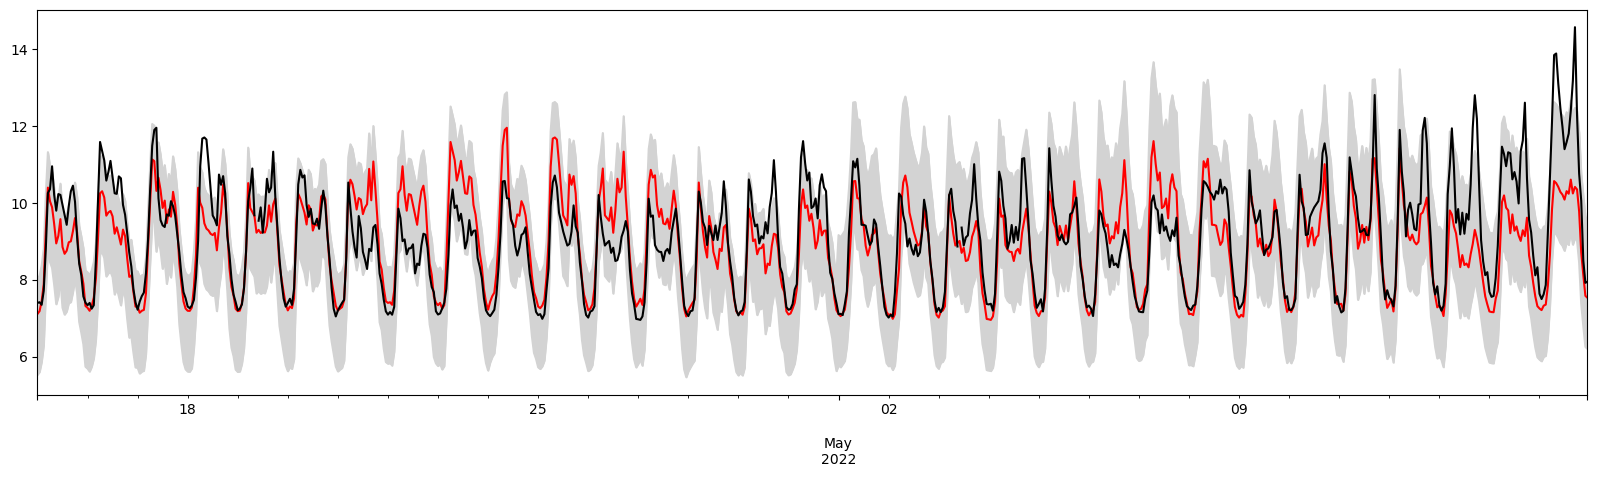

In [16]:
# plot probabilistic predictions in a random week
# start_week = np.random.choice(df_test.index)
# end_week = start_week + pd.DateOffset(days=7)
start_week = '2022-04-15'
end_week = '2022-05-15'
fig, ax = plt.subplots(figsize=(20,5))
dma = 'DMA B (L/s)'

df_naive_test_probabilistic_lower_bound[dma][start_week:end_week].plot(ax=ax, label='Lower bound', color='lightgray', linestyle='-')
df_naive_test_probabilistic_upper_bound[dma][start_week:end_week].plot(ax=ax, label='Upper bound', color='lightgray', linestyle='-')
# fill between the bounds with light grey
ax.fill_between(df_naive_test_probabilistic_lower_bound[dma][start_week:end_week].index, df_naive_test_probabilistic_lower_bound[dma][start_week:end_week], df_naive_test_probabilistic_upper_bound[dma][start_week:end_week], color='lightgrey')
# fill between the bounds with light grey
df_naive_test[dma][start_week:end_week].plot(ax=ax, label='Naive', color='red')

df_test[dma][start_week:end_week].plot(ax=ax, label='Truth', color='black')

In [17]:
# save model
df_naive_test_probabilistic_lower_bound.to_csv(r'../data/processed/naive_test_probabilistic_lower_bound_final.csv')
df_naive_test_probabilistic_upper_bound.to_csv(r'../data/processed/naive_test_probabilistic_upper_bound_final.csv')
df_naive_train_val_probabilistic_lower_bound.to_csv(r'../data/processed/naive_train_val_probabilistic_lower_bound_final.csv')
df_naive_train_val_probabilistic_upper_bound.to_csv(r'../data/processed/naive_train_val_probabilistic_upper_bound_final.csv')